<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan, Aizat Rusli, Abel Thomas-hy</font></h1>
<h1 align=center><font size = 3> ERCE 2021 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\@Working\SPE_Paper'
filename_suffix = 'csv'

##### Read in the data and some preprocessing

In [3]:
skiprows = 4

#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("C&C_database.csv", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,1_Field name,2_Reservoir unit,3_Unique Resource Name,4_Resource category,5_Resource uncertainty,6_Resource maturity,7_Field alias,8_Country,9_State in USA,10_Region,...,330_EOR (pilot),331_EOR (partial application),332_EOR (fieldwide),333_Improved recovery methods (other),334_Improved recovery methods (drilling),335_Improved recovery methods (stimulation),336_Improved recovery methods (water injection optimization),337_Improved recovery methods (artificial lift),338_Improved recovery methods (sand control),339_Improved recovery methods (other reservoir management)
0,25 DE MAYO-MEDANITO SE,QUINTUCO,25 DE MAYO-MEDANITO SE(QUINTUCO)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,NaN,ARGENTINA,NaN,LATIN AMERICA,...,NaN,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT,INFILL WELL,ACIDIZATION/HYDRAULIC FRACTURING (SINGLE STAGE),NaN,ESP,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED,A.J.BERMUDEZ(UNNAMED)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,SAMARIA /CUNDUACAN /IRIDE /OXIACAQUE /TRES PUE...,MEXICO,NaN,LATIN AMERICA,...,NaN,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT/SAND CONTROL,INFILL WELL/HORIZONTAL WELL,ACIDIZATION,NaN,GAS LIFT,SLOTTED LINER,NaN
2,AB TEYMUR,ILAM,AB TEYMUR(ILAM)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,ABTEYMUR /ABTEYMOUR /AB-E-TEIMUR /AB-E-TEYMOUR,IRAN,NaN,MIDDLE EAST,...,NaN,NaN,NaN,STIMULATION,NaN,ACIDIZATION,NaN,NaN,NaN,NaN
3,AB TEYMUR,SARVAK 1,AB TEYMUR(SARVAK 1)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,ABTEYMUR /ABTEYMOUR /AB-E-TEIMUR /AB-E-TEYMOUR,IRAN,NaN,MIDDLE EAST,...,NaN,NaN,NaN,STIMULATION,NaN,ACIDIZATION,NaN,NaN,NaN,NaN
4,ABADI,UPPER PLOVER,ABADI(UPPER PLOVER)(R-3P),RESERVES,3P (PROVED+PROBABLE+POSSIBLE),APPROVED FOR DEVELOPMENT,NaN,INDONESIA,NaN,ASIA-PACIFIC,...,NaN,NaN,NaN,OTHER RESERVOIR MANAGEMENT,NaN,NaN,NaN,NaN,NaN,SIDETRACKING


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Columns: 341 entries, 1_Field name to 339_Improved recovery methods (other reservoir management)
dtypes: float64(226), object(115)
memory usage: 3.8+ MB


There are a huge number of columns here (341 columns in total). This has to be reduced significantly.

1. Listing the column headers in the dataframe via the '.columns' parameter.
2. Executing a brute force drop i.e. if there are columns that have more than a certian % of missing cells, just drop the whole column

In [5]:
# The variable 'a' can be changed to determine which columns to exactly drop. So, if a = 0.9, than if the column contains
# more than 90% null values, drop the column
a = 0.9 

cols_to_delete = df.columns[df.isnull().sum()/len(df) > .90]
cols_to_delete

Index(['20_Hydrocarbon type (tertiary)',
       '27_Discovery well IP (condensate) (BCPD)',
       '30_Well rate (maximum reported condensate) (BCPD)',
       '42_Well count (total suspended injector)',
       '43_Well count (total abandoned injector)',
       '44_Well count (total water injector)',
       '45_Well count (total gas injector)',
       '47_Well count (current active oil producer)',
       '48_Well count (current active gas producer)',
       '50_Well count (current active water injector)',
       ...
       '318_Techniques used to characterize remaining HC',
       '321_Secondary recovery (pilot)',
       '322_Secondary recovery (partial application)',
       '326_EOR methods (thermal)', '327_EOR methods (chemical)',
       '328_EOR methods (miscible)', '329_EOR methods (others)',
       '330_EOR (pilot)', '331_EOR (partial application)',
       '332_EOR (fieldwide)'],
      dtype='object', length=115)

In [6]:
df_new=df[df.columns.drop(cols_to_delete)]
print(df_new.columns.values)
df_new.head(2)

['1_Field name' '2_Reservoir unit' '3_Unique Resource Name'
 '4_Resource category' '5_Resource uncertainty' '6_Resource maturity'
 '7_Field alias' '8_Country' '9_State in USA' '10_Region' '11_Basin name'
 '12_Basin type (Bally)' '13_Basin type (Klemme)' '14_Tectonic regime'
 '15_Latitude' '16_Longitude' '17_Operator company'
 '18_Hydrocarbon type (main)' '19_Hydrocarbon type (secondary)'
 '21_Discovery concept' '22_Technical basis for discovery well'
 '23_Discovery year' '24_Discovery well name'
 '25_Discovery well IP (oil) (BOPD)'
 '26_Discovery well IP (gas) (MMCFGPD)'
 '28_Well rate (maximum reported oil) (BOPD)'
 '29_Well rate (maximum reported gas) (MMCFGPD)'
 '31_First production date' '32_Current status year'
 '33_Current reservoir status' '34_Current production stage'
 '35_Well count (total all wells)'
 '36_Well count (total exploration well)'
 '37_Well count (total appraisal well)' '38_Well count (total producer)'
 '39_Well count (total oil producer)' '40_Well count (total gas

,1_Field name,2_Reservoir unit,3_Unique Resource Name,4_Resource category,5_Resource uncertainty,6_Resource maturity,7_Field alias,8_Country,9_State in USA,10_Region,...,323_Secondary recovery (fieldwide),324_EOR start date,325_EOR methods,333_Improved recovery methods (other),334_Improved recovery methods (drilling),335_Improved recovery methods (stimulation),336_Improved recovery methods (water injection optimization),337_Improved recovery methods (artificial lift),338_Improved recovery methods (sand control),339_Improved recovery methods (other reservoir management)
0,25 DE MAYO-MEDANITO SE,QUINTUCO,25 DE MAYO-MEDANITO SE(QUINTUCO)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,NaN,ARGENTINA,NaN,LATIN AMERICA,...,CONTINUOUS WATER INJECTION,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT,INFILL WELL,ACIDIZATION/HYDRAULIC FRACTURING (SINGLE STAGE),NaN,ESP,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED,A.J.BERMUDEZ(UNNAMED)(R-1P),RESERVES,1P (PROVED),ON PRODUCTION,SAMARIA /CUNDUACAN /IRIDE /OXIACAQUE /TRES PUE...,MEXICO,NaN,LATIN AMERICA,...,CONTINUOUS WATER INJECTION,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT/SAND CONTROL,INFILL WELL/HORIZONTAL WELL,ACIDIZATION,NaN,GAS LIFT,SLOTTED LINER,NaN


Checkpoint 1: Files here are partically cleaned. Columns that are a certain % empty are brute-force dropped

In [7]:
base_filename = 'CP1_Temp_RF_data'
csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
df_new.to_csv(csvs_sht, index = False, header=True)
print ("Final File Extract Produced")

Final File Extract Produced


##### Dropping columns that are either duplicates or else are of secondary importance

In [8]:
# Using a regex method to drop columns pythonically.
# Based on the following syntax and modified
# drop_columns_regex = '^(?!(?:'+'|'.join(drop_column_names)+')$)'

# Column Names to drop
# 0-60 : General well/field information
# 61-80 : Pressure, temeprature, Drive Mech
# 81-109 : Source rock characteristics, incl TOC
# 110-135 : Structure, Depth, Column Height, Dips
# 136-149 : Trap & Seal
# 150-159 : Reservoir Age, Depo Setting, 
# 160-169 : Reservoir Architecture, Number of Reservoir Units
# 170-181 : Reservoir Thickness (Gross, Net), NTG, Net Pay
# 182-194 : Lithology, Grain-Size (SST), Depo texture (LST), Clay type
# 195-217 : Reservoir Type, Porosity Type, Porosity Values, Permeability Values
# 218-266 : PVT Properties, including API, SG, Sulphur, Wax, Methane, CO2, H2S, GOR etc
# 273-289 : Formation Water Properties
# 290-315 : Resource Estimate (OHCIP, EUR), RF
# 319-325 : Secondary Recovery and EOR
# 325-339: Improved Recovery Methods

drop_column_names = [
    '3_', '4_', '6_', '7_','9_','12_','13_','14_','17_', '19_',
    '21_', '22_', '23_', '24_', '25_', '26_', '28_', '29_', 
    '31_', '36_', '37_', '39_', '40_', '41_', '49_', '59_', '60_',
    
    '67_', '68_', '71_', '79_', '83_', '84_', '85_', '86_', '87_', '88_', 
    '89_', '90_', '91_', '92_', '95_', '104_', '105_', '106_', '107_',
    
    '108_', '109_', '110_', '112_', '113_', '114_', '115_', '120_',
    '121_', '121a_', '122_', '123_', '124_', '127_', '130_', '133_',
    '134_', '136_', '137_', '138_', '139_', '140_', '141_', '142_',
    '143_', '144_', '145_', '148_', 
    
    '150_', '151_', '152_', '154_', '155_', '156_', '157_', '158_',
    '159_', '160_', '162_', '165_', '166_', '167_', '168_', '169_',
    
    '171_', '172_', '174_', '175_', '180_', '181_', '183_', '185_',
    '186_', '188_', '190_', '192_', '194_', '195_', '196_',
    
    '197_', '201_', '202_', '203_', '205_', '206_', '211_', '212_',
    '214_', '215_', '216_', '217_', '233_',
    
    '277_', '278_', '280_',
    
    '290_', '291_', '294_', '295_', '297_', '298_',
    
    '323',   
                    ]

# String concat for column drop
drop_columns_regex = '^(('+'|'.join(drop_column_names)+'))'
print('Dropping columns:',', '.join([c for c in df_new.columns if re.search(drop_columns_regex,c)]))

Dropping columns: 3_Unique Resource Name, 4_Resource category, 6_Resource maturity, 7_Field alias, 9_State in USA, 12_Basin type (Bally), 13_Basin type (Klemme), 14_Tectonic regime, 17_Operator company, 19_Hydrocarbon type (secondary), 21_Discovery concept, 22_Technical basis for discovery well, 23_Discovery year, 24_Discovery well name, 25_Discovery well IP (oil) (BOPD), 26_Discovery well IP (gas) (MMCFGPD), 28_Well rate (maximum reported oil) (BOPD), 29_Well rate (maximum reported gas) (MMCFGPD), 31_First production date, 36_Well count (total exploration well), 37_Well count (total appraisal well), 39_Well count (total oil producer), 40_Well count (total gas producer), 41_Well count (total injector), 49_Well count (current active injector), 59_Production rate (current oil) (BOPD), 60_Production rate (current gas) (MMCFGPD), 67_Production rate (peak oil) (BOPD), 68_Production rate (peak gas) (MMCFGPD), 71_Production facilities, 79_Pressure gradient (original) (psi/ft), 83_Drive mechan

In [9]:
# in pandas axis=0 represents rows (default) and axis=1 represents columns.
# Filter based on selected drop columns. Use masking to create new dataframe
data = df_new.filter(regex=drop_columns_regex, axis=1)
data_preproc = df_new[df_new.columns.drop(list(data))]
data_preproc.head(2)

,1_Field name,2_Reservoir unit,5_Resource uncertainty,8_Country,10_Region,11_Basin name,15_Latitude,16_Longitude,18_Hydrocarbon type (main),32_Current status year,...,320_Secondary recovery methods,324_EOR start date,325_EOR methods,333_Improved recovery methods (other),334_Improved recovery methods (drilling),335_Improved recovery methods (stimulation),336_Improved recovery methods (water injection optimization),337_Improved recovery methods (artificial lift),338_Improved recovery methods (sand control),339_Improved recovery methods (other reservoir management)
0,25 DE MAYO-MEDANITO SE,QUINTUCO,1P (PROVED),ARGENTINA,LATIN AMERICA,NEUQUEN,-37.9935,-67.9567,OIL,2012.0,...,CONTINUOUS WATER INJECTION,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT,INFILL WELL,ACIDIZATION/HYDRAULIC FRACTURING (SINGLE STAGE),NaN,ESP,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED,1P (PROVED),MEXICO,LATIN AMERICA,CHIAPAS-TABASCO,17.9833,-93.1000,OIL,2008.0,...,CONTINUOUS WATER INJECTION/GAS INJECTION,NaN,NaN,DRILLING/STIMULATION/ARTIFICIAL LIFT/SAND CONTROL,INFILL WELL/HORIZONTAL WELL,ACIDIZATION,NaN,GAS LIFT,SLOTTED LINER,NaN


##### Rename and simply some of the elements in the various cells.

In [10]:
# Current name of items in column and sum count per type
print(data_preproc["5_Resource uncertainty"].str.get_dummies(sep=', ').sum())

#Split based on open bracket "(", drop extra columns
split_data = data_preproc["5_Resource uncertainty"].str.split("(")
data = split_data.to_list()
names = ["a", "b"]
new_df = pd.DataFrame(data, columns=names).drop(['b'], axis = 1)
#new_df.head()
print("")

# Rename items in column to simplify names
data_preproc2 = pd.concat([data_preproc, new_df], axis = 1)
data_preproc = data_preproc2.drop(['5_Resource uncertainty'], axis = 1)
data_preproc.rename(columns = {'a':'5_Resource uncertainty'}, inplace = True)
print(data_preproc["5_Resource uncertainty"].str.get_dummies(sep=', ').sum())
#print("")
#data_preproc.info()
#data_preproc.head()

1P (PROVED)                      1358
2C (BEST ESTIMATE)                  7
2P (PROVED+PROBABLE)               39
3P (PROVED+PROBABLE+POSSIBLE)      43
dtype: int64

1P     1358
2C        7
2P       39
3P       43
dtype: int64


In [11]:
# Current name of items in column and sum count per type
print(data_preproc["18_Hydrocarbon type (main)"].str.get_dummies(sep=', ').sum())

#Replace names with simpler categories 
# Drop irrelevant data
data_preproc["18_Hydrocarbon type (main)"] = data_preproc["18_Hydrocarbon type (main)"].str.replace('COALBED METHANE', 'GAS')
data_preproc["18_Hydrocarbon type (main)"] = data_preproc["18_Hydrocarbon type (main)"].str.replace('BITUMEN', 'OIL')
data_preproc = data_preproc[~data_preproc["18_Hydrocarbon type (main)"].str.contains("CARBON DIOXIDE")] 

print("")
print(data_preproc["18_Hydrocarbon type (main)"].str.get_dummies(sep=', ').sum())

BITUMEN               6
CARBON DIOXIDE        2
COALBED METHANE       4
GAS                 202
GAS-CONDENSATE      128
OIL                1105
dtype: int64

GAS                206
GAS-CONDENSATE     128
OIL               1111
dtype: int64


In [12]:
# Fixing some of the errors assocaited with the year where the numbers are decimals. Only column 32 has this
data_preproc['32_Current status year'] = df['32_Current status year'].mask(df['32_Current status year'].astype(str).str.startswith('0.'), ' ')

In [13]:
# Current name of items in column and sum count per type
print(data_preproc["82_Drive mechanism (main)"].str.get_dummies(sep=', ').sum())

# Mask out term and replace 
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('aquifer of', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('bottom', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('edge', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('weak', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('moderate', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('strong', case = False, na=False), '82_Drive mechanism (main)'] = 'AQUIFER DRIVE'
data_preproc.loc[data_preproc["82_Drive mechanism (main)"].str.contains('gas', case = False, na=False), '82_Drive mechanism (main)'] = 'GAS DRIVE'

print("")
print(data_preproc["82_Drive mechanism (main)"].str.get_dummies(sep=', ').sum())

AQUIFER OF UNSPECIFIED STRENGTH                                             30
AQUIFER OF UNSPECIFIED STRENGTH/BOTTOM AQUIFER                               6
AQUIFER OF UNSPECIFIED STRENGTH/BOTTOM AQUIFER/EDGE AQUIFER                  6
AQUIFER OF UNSPECIFIED STRENGTH/BOTTOM AQUIFER/EDGE AQUIFER/SOLUTION GAS     2
AQUIFER OF UNSPECIFIED STRENGTH/BOTTOM AQUIFER/SOLUTION GAS                  3
                                                                            ..
WEAK AQUIFER/MODERATE AQUIFER                                                1
WEAK AQUIFER/SOLUTION GAS                                                   37
WEAK AQUIFER/SOLUTION GAS/GAS CAP                                            3
WEAK AQUIFER/SOLUTION GAS/GAS EXPANSION                                      1
WEAK AQUIFER/SOLUTION GAS/GRAVITY DRAINAGE                                   4
Length: 83, dtype: int64

AQUIFER DRIVE           634
CAPILLARY IMBIBITION      1
COMPACTION               13
GAS DRIVE            

In [14]:
# Current name of items in column and sum count per type
print(data_preproc["182_Reservoir lithology (main)"].str.get_dummies(sep=', ').sum())

data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('limestone', case = False, na=False), '182_Reservoir lithology (main)'] = 'CARBONATES'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('dolomite', case = False, na=False), '182_Reservoir lithology (main)'] = 'CARBONATES'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('chalk', case = False, na=False), '182_Reservoir lithology (main)'] = 'CARBONATES'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('diatomite', case = False, na=False), '182_Reservoir lithology (main)'] = 'SANDSTONE'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('chert', case = False, na=False), '182_Reservoir lithology (main)'] = 'SANDSTONE'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('Sandstone', case = False, na=False), '182_Reservoir lithology (main)'] = 'SANDSTONE'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('siltstone', case = False, na=False), '182_Reservoir lithology (main)'] = 'SANDSTONE'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('conglomerate', case = False, na=False), '182_Reservoir lithology (main)'] = 'OTHERS'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('volcanics', case = False, na=False), '182_Reservoir lithology (main)'] = 'OTHERS'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('coal', case = False, na=False), '182_Reservoir lithology (main)'] = 'OTHERS'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('basement', case = False, na=False), '182_Reservoir lithology (main)'] = 'OTHERS'
data_preproc.loc[data_preproc["182_Reservoir lithology (main)"].str.contains('shale', case = False, na=False), '182_Reservoir lithology (main)'] = 'OTHERS'

print("")
print(data_preproc["182_Reservoir lithology (main)"].str.get_dummies(sep=', ').sum())

BASEMENT                                        22
CHALK                                           23
CHALKY LIMESTONE                                27
CHERT                                            4
CHERT/SILTSTONE                                  1
COAL                                             4
CONGLOMERATE                                    18
CONGLOMERATE/SANDSTONE                           1
DIATOMITE                                        3
DOLOMITE                                       165
DOLOMITE/DOLOMITIC LIMESTONE                     3
DOLOMITE/LIMESTONE                               1
DOLOMITIC LIMESTONE                             16
GLAUCONITIC SANDSTONE                            5
LIMESTONE                                      200
LOW-RESISTIVITY SANDSTONE                       39
LOW-RESISTIVITY SANDSTONE/SHALY SANDSTONE        2
SANDSTONE                                      822
SANDSTONE/GLAUCONITIC SANDSTONE                  1
SANDSTONE/SILICEOUS SHALE      

In [15]:
# Combine some columns to reduce column count
data_preproc['52_Well spacing (average) (ac)'] = data_preproc['52_Well spacing (current oil average) (ac)'].fillna(0) + data_preproc['55_Well spacing (current gas average) (ac)'].fillna(0)
data_preproc['73_Water_Depth (ft)'] = data_preproc['74_Water depth (ft)'].fillna(0) - data_preproc['73_Elevation (ft)'].fillna(0)
data_preproc['218_API gravity (average) (deg. API)'] = data_preproc['218_API gravity (oil average) (deg. API)'].fillna(0) + data_preproc['221_API gravity (condensate average) (deg. API)'].fillna(0)
data_preproc['236_Oil_impurities (average)'] = data_preproc['236_Sulphur (average) (%)'].fillna(0) + data_preproc['239_Wax (average) (%)'].fillna(0)
data_preproc['243_Gas_impurities (average)'] = data_preproc['243_Carbon dioxide (average) (%)'].fillna(0) + data_preproc['246_Hydrogen sulphide (average) (%)'].fillna(0) + data_preproc['249_Nitrogen (average) (%)'].fillna(0)

data_preproc = data_preproc.drop([
    '52_Well spacing (current oil average) (ac)', '55_Well spacing (current gas average) (ac)',
    '74_Water depth (ft)', '73_Elevation (ft)',
    '218_API gravity (oil average) (deg. API)', '221_API gravity (condensate average) (deg. API)',
    '236_Sulphur (average) (%)', '239_Wax (average) (%)',
    '243_Carbon dioxide (average) (%)', '246_Hydrogen sulphide (average) (%)', '249_Nitrogen (average) (%)',   
], axis = 1)

In [16]:
data_preproc['184_Grain_Size_Texture'] = data_preproc['184_Grain size for clastics (dominant)'].fillna('') + data_preproc['187_Depositional texture for carbonates (main)'].fillna('')
data_preproc['189_Composition'] = data_preproc['189_Depositional composition for clastics (main)'].fillna('') + data_preproc['191_Depositional component for carbonates (main)'].fillna('')

data_preproc = data_preproc.drop([
    '184_Grain size for clastics (dominant)', '187_Depositional texture for carbonates (main)',
    '189_Depositional composition for clastics (main)', '191_Depositional component for carbonates (main)',
], axis = 1)   

##### Sort the columns so that it reads incrementally

In [17]:
data_preproc = data_preproc.reindex(natsorted(data_preproc.columns), axis=1)
#data_preproc.columns.values
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 0 to 1446
Data columns (total 89 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   1_Field name                                                  1445 non-null   object 
 1   2_Reservoir unit                                              1445 non-null   object 
 2   5_Resource uncertainty                                        1445 non-null   object 
 3   8_Country                                                     1445 non-null   object 
 4   10_Region                                                     1445 non-null   object 
 5   11_Basin name                                                 1445 non-null   object 
 6   15_Latitude                                                   1445 non-null   float64
 7   16_Longitude                                                  1445 no

A quick visualisation to observe for empty cells, if cells have been dropped correctly and if the data needs more cleaning up

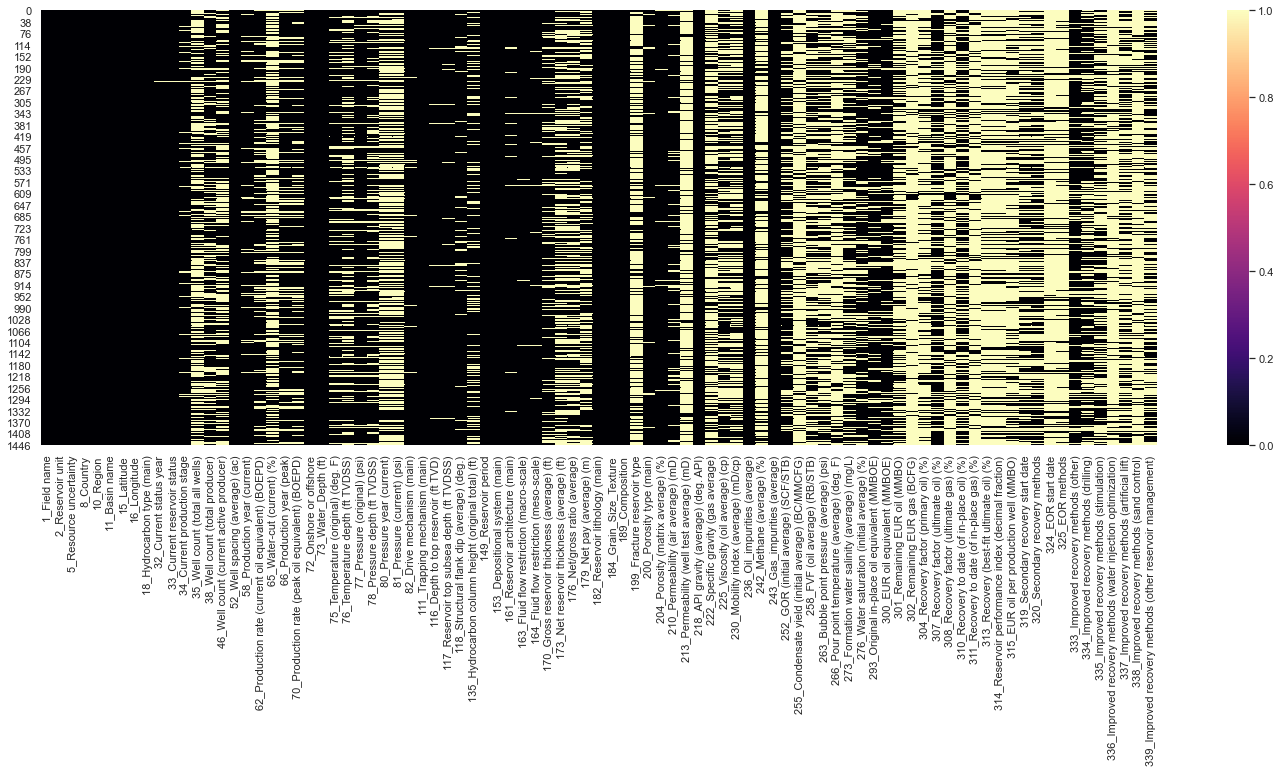

In [18]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(data_preproc.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

Split into Sandstone and Carbonate Reservoirs

In [24]:
df_sst = data_preproc[data_preproc["182_Reservoir lithology (main)"] =='SANDSTONE']
df_carb = data_preproc[data_preproc["182_Reservoir lithology (main)"] =='CARBONATES']

Checkpoint 2: Files here are fully cleaned and ready for modelling.

In [25]:
def file_out(df, dir_name, base_filename, filename_suffix):
    csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
    df.to_csv(csvs_sht, index = False, header=True)
    return

file_out(data_preproc, dir_name, 'CP2_Clean_RF_data' , filename_suffix)
file_out(df_sst, dir_name, 'CP3_SST_RF_data' , filename_suffix)
file_out(df_carb, dir_name, 'CP4_CARB_RF_data' , filename_suffix)

print ("Final File Extract Produced")

Final File Extract Produced


In [21]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 8.92444133758545 seconds
